# Практическое задание 4 

# Мультиязычный тематический поиск

## курс "Математические методы анализа текстов"


### ФИО: <впишите>

## Введение

### Постановка задачи:

В этом задании вам предстоит сделать свою небольшую мультиязычную поисковую систему. Проще всего строить мультиязычные системы, имея "параллельные" данные: словари или корпуса параллельных текстов. 

В задании необходимо, имея англо-русскую и агло-испанскую коллекции, обучить модель поиска модель поиска испанских текстов по русским.

Решение этого задания будет основано на тематическом моделировании, а именно подходе аддитивной регуляризации.

### Библиотеки

Для этого задания вам понадобятся следующие библиотеки:
 - [bigartm](http://bigartm.org/)
 - [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/)
 - [nltk](http://www.nltk.org/)


### Данные

Данные — записи выступлений конференции TED Talks на трёх языках. 

Все данные содержатся в архиве `ted_collection`. В папке содержится три подпапки `/en`, `/ru` и `/es`, каждая из которых соответствует коллекции для отдельного языка. Папка `parallel_info`  содержит информацию о связях документов между коллекциями. Файл `titles_file.json` содержит информацию о заголовках документов английской коллекции.

Ссылка для скачивания данных: [ссылка на гугл диск](https://drive.google.com/file/d/1B3kDfISvWnVpEet_CDa6oLNp028mEak-/view)

#### Импорт важных библиотек

In [1]:
# считывание
import os
import glob
import json

# предобработка
import pymystem3
import nltk
import re

# тематическое моделирование
import artm

# change log style for artm
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline

# прочее 
import numpy as np

#### Несколько важных промежуточных функций

In [2]:
# загрузка коллекции
from lab4_utils import load_collection

# загрузка информации о параллельных документах
from lab4_utils import load_parallel_documents_info

# запись vowpal wabit файла специального формата
from lab4_utils import write_vw_lab4

# подсчёт позиции в выдаче переводов текстов
from lab4_utils import get_indexes_of_relevant_documents

## Предобработка данных (3 балла)

Перед тем как начать моделировать, необходимо предобработать данные. 

Заметим, что для английского языка некоторые этапы обработки не оказывают сильного влияния на модель (например, лемматизация). В русском языке одному слову может соответствовать огромное количество различных форм, поэтому без лемматизации невозможно получить модель с хорошим качеством.

#### Предобработка русских текстов


Считываем коллекцию:

In [3]:
RU_DATA_PATH = 'ted_collection/ru'
ru_collection = load_collection(RU_DATA_PATH, verbose=True)

Total number of documents: 2731

Some document examples: 
	10 марта 2011 года я был в Кембридже в MIT Media Lab на встрече с профессорами, студентами и персона...
	Последние 10 лет я провёл, пытаясь понять, как и почему люди объединяются в социальные сети. Социаль...
	Кое-что в физике не давало мне покоя с самого детства. Речь идёт о вопросе, которым учёные задаются ...
	26 января 2013 года боевики «Аль-Каиды» ворвались в древний город Тимбукту на юге Сахары. Они подожг...
	Вам знакомо расхожее мнение, что защита климата – занятие дорогое, иначе проблема была бы давно реше...

Some file names examples: 
	ru_2334
	ru_1783
	ru_2106
	ru_927
	ru_2562


In [8]:
type(ru_collection)

dict

Выведите полностью несколько документов. Подумайте, какую информацию из них можно удалить на этапе предобработки, не ухудшив качество решения задачи.

In [12]:
def ru_delete_trash(text):
#     delete (Аплодисменты)
    text = text.replace("(Аплодисменты)", "")
    
#     remove last eng symbols
    text = text[:text.rfind("TED.com")]
    
    return text

Помимо удаления специфичной информации, вам необходимо провести для русского языка следующие шаги предобработки :

1. Приведение документов к нижнему регистру.

2. Удаление всех символов кроме букв.
    1. Для некоторых способов выделения коллокаций (см. бонусную часть), может быть полезна информация о знаках препинания. Также она полезна при необходимости строить синтаксический разбор предложения.
    2. Вам может помочь функция sub из библиотеки re.
3. Токенизация документов.
    1. Воспользуйтесь стандартным методом .split, функцией split из библиотеки re или одним из токенайзеров библиотеки nltk.
4. Лемматизация документов.
    1. Воспользуйтесь библиотекой pymorphy2
    2. Шаги 3 и 4 можно выполнить вместе, воспользовавшись библиотекой mytem (или её обёрткой на python pymystem)
5. Удаление стоп-слов
    1. Базовый список стоп слов можно получить из модуля nltk.corpus

После выполнения всех шагов сохраните результат в словарь аналогичный ru_collection (ключи - названия файлов, значения - предобработанный документ в формате str).



In [16]:
m = pymystem3.Mystem()
STOPWORDS_ru = nltk.corpus.stopwords.words('russian') + [' ', '\n']

def preprocess_ru(text):
    text = text.lower()
    text = re.sub(r'[^\w ]', ' ', text)
    text = re.sub(r'\d_', '', text)
    text = re.sub(r'[\s]+', ' ', text)
    text = m.lemmatize(text)
    text = [word for word in text if word not in STOPWORDS_ru]
    return text

In [17]:
preprocessed_ru_collection = {}
for key in list(ru_collection.keys())[:50]:
    preprocessed_ru_collection[key] = preprocess_ru(ru_delete_trash(ru_collection[key]))

In [18]:
preprocessed_ru_collection

{'ru_2334': ['10',
  'март',
  '2011',
  'год',
  'кембридж',
  'mit',
  'media',
  'lab',
  'встреча',
  'профессор',
  'студент',
  'персонал',
  'пытаться',
  'выяснивать',
  'следовать',
  'следующий',
  'руководитель',
  'ночь',
  'полночь',
  'землетрясение',
  'сила',
  '9',
  'балл',
  'ударять',
  'тихоокеанский',
  'побережье',
  'япония',
  'жена',
  'семья',
  'япония',
  'мера',
  'поступление',
  'новость',
  'начинать',
  'паниковать',
  'смотреть',
  'новостной',
  'лента',
  'слушать',
  'пресс',
  'конференция',
  'представитель',
  'правительство',
  'компания',
  'tokyo',
  'power',
  'взрыв',
  'ядерный',
  'реактор',
  'облако',
  'радиоактивный',
  'осадки',
  'двигаться',
  'направление',
  'дом',
  '200',
  'километр',
  'телевизор',
  'говорить',
  'ничто',
  'хотеться',
  'слышать',
  'хотеть',
  'знать',
  'происходить',
  'реактор',
  'радиация',
  'опасность',
  'семья',
  'сделать',
  'инстинктивно',
  'казаться',
  'правильный',
  'именно',
  'зайти',
  

Проанализируйте несколько предобработанных документов. Отметьте, какие неточности работы алгоритмов вы заметили, и как они могут повлиять на итоговую модель.

Некоторые стопслова не содержаться в nltk.corpus, например 'это'

#### Предобработка английских текстов

Считываем коллекцию:

In [10]:
EN_DATA_PATH = 'ted_collection/en'
en_collection = load_collection(EN_DATA_PATH, verbose=True)

Total number of documents: 2856

Some document examples: 
	Today, I want you to look at children who become suicide bombers through a completely different lens...
	I have a very difficult task. I'm a spectroscopist. I have to talk about astronomy without showing y...
	I really am honored to be here, and as Chris said, it's been over 20 years since I started working i...
	Thirteen years ago, we set ourselves a goal to end poverty. After some success, we've hit a big hurd...
	One thing the world needs, one thing this country desperately needs is a better way of conducting ou...

Some file names examples: 
	en_495
	en_1635
	en_2282
	en_1407
	en_1063


Проведите все этапы предобработки для английского языка (шаг 4 опционален, можно использовать WordNetLemmatizer из nltk):

In [11]:
STOPWORDS_en = nltk.corpus.stopwords.words('english')

def en_delete_trash(text):
#     delete (Аплодисменты)
    text = text.replace("(Applause)", "")
    
#     remove last eng symbols
    text = text[:text.rfind("TED.com")]
    return text

def preprocess_en(text):
    text = text.lower()
    text = re.sub(r'[^\w ]', ' ', text)
    text = re.sub(r'\d_', '', text)
    text = re.sub(r'[\s]+', ' ', text)
    text = text.split(" ")
    text = [word for word in text if word not in STOPWORDS_en]
    return text
    
    return text

In [17]:
preprocessed_en_collection = {}
for key in list(en_collection.keys()):
    preprocessed_en_collection[key] = preprocess_en(en_delete_trash(en_collection[key]))

#### Предобработка испанских текстов 

Считываем коллекцию:

In [18]:
ES_DATA_PATH = 'ted_collection/es'
es_collection = load_collection(ES_DATA_PATH, verbose=True)

Total number of documents: 2809

Some document examples: 
	Era mi tercer día de trabajo en una empresa emergente en Silicon Valley a principios de 2013. Tenía ...
	Estamos en un momento crítico. Nuestros líderes, algunas de nuestras grandes instituciones nos están...
	Este es el museo de Historia Natural de Rotterdam, donde trabajo como curador. Cuido la colección y ...
	Chris Anderson: Vamos a tener un debate. El debate es sobre la propuesta: "Lo que el mundo necesita ...
	Soy microbióloga oceanográfica en la Universidad de Tennessee, y quiero hablarles sobre algunos micr...

Some file names examples: 
	es_1801
	es_309
	es_907
	es_1459
	es_2826


Проведите все этапы предобработки для испанского языка (шаг 4 опционален, можно использовать SpanishStemmer из nltk). 

**Замечание.** Регулярное выражение \w из библиотеки re позволяет выделять буквы (в том числе буквы испанского алфавита).

In [19]:
STOPWORDS_es = nltk.corpus.stopwords.words('spanish')
st = nltk.stem.snowball.SpanishStemmer()

def es_delete_trash(text):
#     delete (Аплодисменты)
    text = text.replace("(Aplausos)", "")
    
#     remove last esp symbols
    text = text[:text.rfind("TED.com")]
    return text

def preprocess_es(text):
    text = text.lower()
    text = re.sub(r'[^\w ]', ' ', text)
    text = re.sub(r'\d_', '', text)
    text = re.sub(r'[\s]+', ' ', text)
    text = text.split(" ")
    text = [st.stem(word) for word in text if word not in STOPWORDS_es]
    return text
    
    return text

In [20]:
preprocessed_es_collection = {}
for key in list(es_collection.keys()):
    preprocessed_es_collection[key] = preprocess_es(es_delete_trash(es_collection[key]))

#### Дополнительная предобработка

Библиотека BigARTM имеет собственный формат документов для обработки, называемый батчами. Самый простой способ создать батчи из коллекции файлов - сконвертировать в батчи vowpal wabbit файл с коллекцией (https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format). 

Тематические модели работают с мешком слов, поэтому в vowpal wabbit файле можно не хранить информацию о порядке слов в документе.

Чтобы обучить мультиязычную модель, мы будем использовать апарат модальностей тематической модели. Каждому языку будет соответствовать своя модальность (`@english`, `@russian` и `@spanish` в vowpal wabbit файле). 

Для экспериментов нам понадобится два файла. Один будет содержать информацию о параллельных документов, а другой нет. В втором файле каждая строчка соответствует конкретному документу. В первом файле, если у документа есть параллельный, он будет располагаться на этой же строчке в рамках другой модальности.

Весь код для сохранения файла в vowpal wabbit формате уже написан, вам только необходимо правильно воспользоваться функцией. В частности, проследите, чтобы в ваших документах не содержалось символов ':', '|' и '@'.

В файлах en_ru_match.txt и en_es_match.txt содержится информация о том, какие документы являются параллельными. 

In [21]:
en_ru_parallel_docs = load_parallel_documents_info('ted_collection/parallel_info/en_ru_match.txt')
en_es_parallel_docs = load_parallel_documents_info('ted_collection/parallel_info/en_es_match.txt')

Total number of pairs: 1000
Total number of pairs: 1000


Воспользуйтесь функцией write_vw_lab4, чтобы сохранить данные в нужном формате:

In [19]:
def write_vw(output_path,
                  ru_cleaned_collection):
    with open(output_path, 'w') as f_output:
        
        for ru_file_name, ru_content in ru_cleaned_collection.items():
            new_document = '{} {}'.format(ru_file_name, ru_content)
            f_output.write(new_document + '\n')

In [23]:
write_vw('trash.vw', preprocessed_ru_collection)
batch_vectorizer_mono = artm.BatchVectorizer(data_path='trash.vw', 
                                             data_format='vowpal_wabbit',
                                             target_folder='trash')

dictionary = artm.Dictionary()
dictionary.gather(data_path='trash')
model = artm.ARTM(num_topics=30,
                  num_processors=7,
                  theta_columns_naming='title')

model.initialize(dictionary)
model.fit_offline(batch_vectorizer_mono, num_collection_passes=10)

In [22]:
# vowpal wabbit файлы с коллекцией
DATA_PATH_PARALLEL = 'ted_collection/collection_parallel.vw'
DATA_PATH_MONO = 'ted_collection/collection_mono.vw'

write_vw_lab4(
    DATA_PATH_PARALLEL,
    preprocessed_en_collection,
    preprocessed_ru_collection,
    preprocessed_es_collection,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=True
)


write_vw_lab4(
    DATA_PATH_MONO,
    preprocessed_en_collection,
    preprocessed_ru_collection,
    preprocessed_es_collection,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=False
)

## Базовая моноязычная тематическая модель (2 балла)

Теорию тематического моделирования можно узнать из лекций [9](http://www.machinelearning.ru/wiki/images/7/79/Mmta2018-artm-1.pdf) и [10](http://www.machinelearning.ru/wiki/images/a/ab/Mmta2018-artm-2.pdf).

Научиться пользоваться bigartm легче всего по гайду из документации [ссылка](http://docs.bigartm.org/en/stable/tutorials/python_userguide/index.html).

#### Подготовка к моделированию

Чтобы преобразовать полученный vowpal wabbit файл в батчи, можно воспользоваться стандартным классом BatchVectorizer. Объект этого класса принимает на вход адрес папки с батчами или файл vowpal wabbit, а затем подаётся на вход для обучения методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

В этой части экспериментов, вам предлагается построить моноязычную тематическую модель только для английского языка, поэтому для обучения используйте файл DATA_PATH_MONO.

In [23]:
# папка с батчами
BATCHES_PATH_MONO = 'ted_collection/batch_mono'

In [24]:
# если BATCHES_PATH_MONO пуста, батчи будут созданы из файла в DATA_PATH_MONO
# иначе использовать BATCHES_PATH_MONO
if len(glob.glob(os.path.join(BATCHES_PATH_MONO + '/*.batch'))) < 1:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=DATA_PATH_MONO, 
                                                 data_format='vowpal_wabbit',
                                                 target_folder=BATCHES_PATH_MONO)
else:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=BATCHES_PATH_MONO,
                                                 data_format='batches')

Словарь – это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.

In [25]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=BATCHES_PATH_MONO)

Словарь в том числе отвечает за то, на какие токены будет настраиваться модель. Редкие слова не оказывают влияние на модель, поэтому их можно удалить используя метод .filter.

In [26]:
MIN_DF = 5

dictionary.filter(min_df=MIN_DF)

artm.Dictionary(name=411ebdd0-6d06-43a0-b078-9cd5cc5f9ca6, num_entries=54032)

#### Обучение модели

Пришло время приступить к моделированию! Начнём с простой одноязычной модели PLSA. Будем учитывать только модальность @english в документах коллекции. Так как коллекция небольшая, используйте небольшое число тем 30-50.

Параметр theta_columns_naming='title' отвечает за именование документов лейблами из vowpal wabbit формата при получении матрицы $\Theta$ (иначе они будут нумероваться в порядке появления в коллекции).

In [28]:
model = artm.ARTM(num_topics=30,
                  num_processors=7,
                  theta_columns_naming='title',
                  class_ids={'@english':1})

model.initialize(dictionary)

Класс artm.ARTM поддерживает различные встроенные метрики качества. Добавьте метрики измерения перплексии, разреженности $\Phi$, разреженности $\Theta$ и счётчик топ слов. Не забудьте, что метрики должны соответствовать только модальности @english!

In [29]:
model.scores.add(artm.PerplexityScore(name='perplexity_score', class_ids=['@english']))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='@english'))
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='@english'))

Проведите обучение модели с помощью метода fit_offline. Подберите необходимое число операций для сходимости в зависимости от значения перплексии:

In [30]:
model.fit_offline(batch_vectorizer_mono, num_collection_passes=150)

Выведите график изменения перплексии в зависимости от итерации алгоритма, чтобы мы знали, что ваш алгоритм точно сошёлся :)

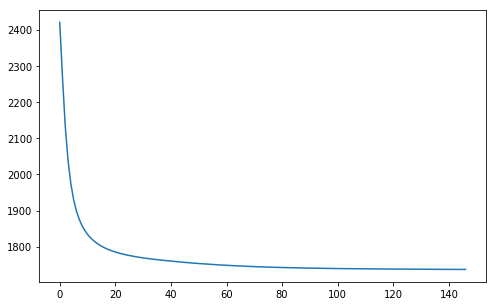

In [31]:
plt.figure(figsize=(8,5))
plt.plot(model.score_tracker['perplexity_score'].value[3:])

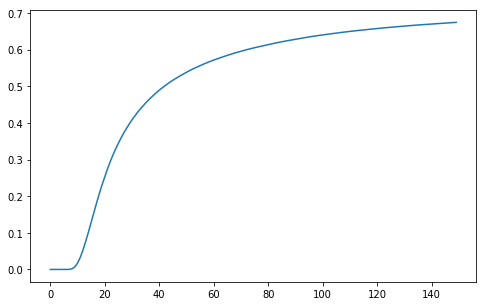

In [32]:
plt.figure(figsize=(8,5))
plt.plot(model.score_tracker['sparsity_phi_score'].value)

#### Интерпретация результатов

Основная особенность тематических моделей — интерпретируемость получаемых матриц $\Phi$ и $\Theta$. С помощью $\Phi$ для каждой темы можно узнать топ-слова, а с помощью $\Theta$ для каждой темы можно узнать топ-документы. 
Для того, чтобы получить матрицу $\Theta$, используйте метод .transform.

Для каждой темы выведите топ её слов ($\geq 20$) и топ заголовкой её документов ($\geq 5$). Попробуйте интерпертировать полученные темы, действительно ли темы получаются осмысленными?

In [33]:
file_name_to_title = {}
with open('ted_collection/titles_file.json') as f:
    for line in f:
        file_name_to_title.update(json.loads(line))

In [34]:
## DOCS
theta = model.transform(batch_vectorizer_mono)

topic2top_docs = {}
for row_name, row in theta.iterrows():
    topic2top_docs[row_name] = [file_name_to_title[el] for el in list(row.sort_values(ascending=False)[:5].index)]
    
    
## WORDS
phi = model.get_phi()

topic2top_words = {}
for row_name, row in phi.T.iterrows():
    topic2top_words[row_name] = list(row.sort_values(ascending=False)[:5].index)

In [38]:
for key in list(topic2top_words.keys())[:5]:

    print("\x1b[31m" + key + " WORDS: \x1b[0m")
    for el in [el[1][1:-2] for el in topic2top_words[key]]:
        print(el, end=', ')
    print()
    print("\x1b[31m" + key + " DOCS TITLES: \x1b[0m")
    for el in topic2top_docs[key]:
        print(el)
    print('-' * 100)

topic_0 WORDS: 
women, men, woman, girls, sex, 
topic_0 DOCS TITLES: 
Sofia Jawed-Wessel: The lies we tell pregnant women
Peggy Orenstein: What young women believe about their own sexual pleasure
Frans de Waal: The surprising science of alpha males
Jackson Katz: Violence against women -- it's a men's issue
Chimamanda Ngozi Adichie: We should all be feminists
----------------------------------------------------------------------------------------------------
topic_1 WORDS: 
life, day, would, one, years, 
topic_1 DOCS TITLES: 
Tan Le: My immigration story
Hyeonseo Lee: My escape from North Korea
Melissa Fleming: A boat carrying 500 refugees sunk at sea. The story of two survivors
Tania Luna: How a penny made me feel like a millionaire
Joseph Kim: The family I lost in North Korea. And the family I gained.
----------------------------------------------------------------------------------------------------
topic_2 WORDS: 
government, information, people, us, internet, 
topic_2 DOCS TITLES: 

Часто, топ 5 слов достаточно что бы понять смысл темы. Однако, иногда их бывает недостаточно. В таких случаях трудно понять смысл темы, как видно в topic_1, topic_22. Но в этом случае помогают названия документов.

В topic_10 и topic_12 в топ 5 слов попало слово us, которое почему-то не состоит в стоп-словах, его стоит туда добавить.

Возможно, стоит уменьшить число тем, так как темы некоторых документов достаточно похожи.

## Мультиязычная тематическая модель (5 баллов)

В этом пункте задания вам будет необходимо обучить мультиязычную тематическую модель.

В данном пункте вы будете реализовывать модель ML-TD (MultiLingual Parallel).

* каждый язык — отдельная модальность
* $\theta_{td}$ — общая для всех параллельных документов

Таким образом на обучении все параллельные документы записываются в одну строку в vowpal wabbit файле.

Оценивать качество модели мы будем на задаче поиска перевода текста. Вам будет необходимо оценить качество трёх переводов: с русского на английский, с испанского на английский и с русского на испанский.

Поиск документов будет устроен следующим образом. Будем для документа d на языке A считать близости со всеми документами на языке B и ранжировать документы языка B по этой близости. Для каждого документа посчитаем позицию истинного перевода документа в выдаче. Итоговая метрика — медиана или среднее таких позиций по всем документам.

Выделим множества документов, для которых не было известно информации об их переводе:

In [40]:
ru_es_parallel_docs_test = load_parallel_documents_info('ted_collection/parallel_info/ru_es_match_test.txt', verbose=False)
ru_en_parallel_docs_test = load_parallel_documents_info('ted_collection/parallel_info/ru_en_match_test.txt', verbose=False)
es_en_parallel_docs_test = load_parallel_documents_info('ted_collection/parallel_info/es_en_match_test.txt', verbose=False)

Проведите подготовительный этап (создание батчей и словарей) для мультиязычной коллекции DATA_PATH_PARALLEL.

In [41]:
# папка с батчами
BATCHES_PATH_PARALLEL = 'ted_collection/batch_parallel'

In [42]:
# если BATCHES_PATH_MONO пуста, батчи будут созданы из файла в DATA_PATH_PARALLEL
# иначе использовать BATCHES_PATH_MONO
if len(glob.glob(os.path.join(BATCHES_PATH_PARALLEL + '/*.batch'))) < 1:
    batch_vectorizer_parallel = artm.BatchVectorizer(data_path=DATA_PATH_PARALLEL, 
                                                 data_format='vowpal_wabbit',
                                                 target_folder=BATCHES_PATH_PARALLEL)
else:
    batch_vectorizer_parallel = artm.BatchVectorizer(data_path=BATCHES_PATH_PARALLEL,
                                                 data_format='batches')

In [43]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=BATCHES_PATH_PARALLEL)

In [44]:
MIN_DF = 5

dictionary.filter(min_df=MIN_DF)

artm.Dictionary(name=d8d17106-e133-4880-a6ba-0cc50463582a, num_entries=54032)

Обучите мультиязычную модель и проинтерпертируйте полученные темы. Если вы всё сделали правильно, то топ-слова различных языков для одной темы должны получиться достаточно похожими.

In [45]:
kf_es, kf_en, kf_ru = 0.35, 0.9, 0.50

model = artm.ARTM(num_topics=16,
                  num_processors=-1,
                  theta_columns_naming='title',
                  class_ids={'@english': kf_en, '@spanish': kf_es, '@russian': kf_ru})

model.initialize(dictionary)

for it in range(5):
    model.fit_offline(batch_vectorizer_parallel, num_collection_passes=40)

    idxs__ru_en, _ = get_indexes_of_relevant_documents(model.transform(batch_vectorizer_mono),
                                                       ru_en_parallel_docs_test)
    idxs__ru_es, _ = get_indexes_of_relevant_documents(model.transform(batch_vectorizer_mono),
                                                       ru_es_parallel_docs_test)
    idxs__es_en, _ = get_indexes_of_relevant_documents(model.transform(batch_vectorizer_mono),
                                                       es_en_parallel_docs_test)
    print(it, ':')
    print(np.median(idxs__ru_en), np.mean(idxs__ru_en))
    print(np.median(idxs__ru_es), np.mean(idxs__ru_es))
    print(np.median(idxs__es_en), np.mean(idxs__es_en))
    print('-' * 20)

0 :
4.0 49.535
19.0 102.125
1.0 37.4675
--------------------
1 :
1.0 22.315
2.0 30.70375
0.0 8.45375
--------------------
2 :
0.0 12.72
1.0 14.42875
0.0 3.37875
--------------------
3 :
0.0 8.4625
0.0 9.87
0.0 3.22625
--------------------
4 :
0.0 7.1375
0.0 8.38
0.0 3.65
--------------------


Протестируйте качество на трёх задачах перевода. Добейтесь хорошего качества (медиана позиции в выдаче ~ 0, среднее ~ 10). Получить положение в выдаче переводов текстов вам поможет функция get_indexes_of_relevant_documents из модуля lab4_utils. Для того, чтобы всё работало корректно (на тесте не должна быть известна информация о параллельности документов), подавайте в качестве theta результат model.transform(batch_vectorizer_mono).

Возможные способы улучшения:
* изменять количество тем, количество итераций обучения
* изменять веса модальностей
* добавлять регуляризаторы (см. бонусную часть)
* изменять метрику для поиска ближайших документов
* добавлять шаги в предобработку (выделение колокаций)

За нетривиальные подходы могут быть начислены дополнительные бонусные баллы!

In [48]:
tmp = get_indexes_of_relevant_documents(model.transform(batch_vectorizer_mono), ru_en_parallel_docs_test)
print(np.median(tmp[0]), np.mean(tmp[0]))

tmp = get_indexes_of_relevant_documents(model.transform(batch_vectorizer_mono), ru_es_parallel_docs_test)
print(np.median(tmp[0]), np.mean(tmp[0]))

tmp = get_indexes_of_relevant_documents(model.transform(batch_vectorizer_mono), es_en_parallel_docs_test)
print(np.median(tmp[0]), np.mean(tmp[0]))

0.0 7.1375
0.0 8.38
0.0 3.65


Проведите анализ ошибок. На каких документах модель отработала лучше всего, на каких хуже всего? Как вы думаете почему?

In [50]:
theta = model.transform(batch_vectorizer_mono)
parallel_docs = ru_en_parallel_docs_test
metric = 'cosine'

theta_T = theta.T
embeddigns_norms = (theta_T ** 2).sum(axis=1) ** 0.5

one_language_relevant_docs, _ = zip(*parallel_docs.items())
one_language_relevant_docs = list(one_language_relevant_docs)
one_language_relevant_embeddings = (
    theta_T
    .loc[one_language_relevant_docs]
)
one_language_relevant_norms = (
    embeddigns_norms
    .loc[one_language_relevant_docs]
)

second_language_example = next(iter(parallel_docs.values()))
second_language_docs = [
    document
    for document in theta_T.index
    if document[:2] == second_language_example[:2]
]
second_language_embeddings = theta_T.loc[second_language_docs]
second_language_norms = embeddigns_norms.loc[second_language_docs]

similarity_matrix = (
    one_language_relevant_embeddings
    .dot(second_language_embeddings.T)
)

if metric == 'cosine':
    similarity_matrix = similarity_matrix.div(one_language_relevant_norms, axis='index')
    similarity_matrix = similarity_matrix.div(second_language_norms, axis='columns')

similarity_matrix_array = similarity_matrix.values
estimations = similarity_matrix_array.argsort(axis=1)[:, ::-1]
second_lang_doc_to_number = dict(zip(similarity_matrix.columns,
                                     range(len(similarity_matrix.columns))))

result_index = []
docs_pair = []

for i, one_document in enumerate(similarity_matrix.index):
    if parallel_docs[one_document] not in similarity_matrix.columns:
        continue
    doc_index = second_lang_doc_to_number[
        parallel_docs[one_document]
    ]
    index_in_output = np.where(estimations[i] == doc_index)[0]
    result_index.append(index_in_output[0])
    docs_pair.append((one_document, parallel_docs[one_document]))

In [161]:
np.mean([len(ru_collection[i]) for i in similarity_matrix.index])

11225.8325

In [159]:
all_ = []

for i, el in enumerate(result_index):
    if el > 0:
        all_.append(len(ru_collection[similarity_matrix.index[i]]))

In [160]:
np.mean(all_)

10503.84879725086

In [157]:
i = 1

one_document = similarity_matrix.index[i]
ru_collection[one_document][:1000]

"Одной из самых сложных задач в компьютерной графике было создание фото-реалистичного цифрового лица человека. Одна из причин, почему это так сложно сделать, в отличие от инопланетян или динозавров, заключается в том, что мы видим человеческие лица каждый день. Они очень важны для нас при общении друг с другом. В результате мы обращаем внимание на мельчайшие детали, с которыми может быть что-то не так при компьютерном воспроизведении, для того чтобы поверить, что эти детали выглядят реалистично.\nВ течение следующих 5 минут я объясню вам процесс, в ходе которого мы попытались создать на компьютере достаточно фото-реалистичное лицо с помощью разработанной нами технологии компьютерной графики, а также нескольких коллег из компании Image Metrics. Мы постараемся воссоздать фото-реалистичное лицо актрисы Эмили О' Брайен. Вот она. Это действительно полностью созданное на компьютере изображение её лица. В конце презентации мы увидим, как оно движется.\nИтак, мы начали с самой Эмили, которая л

Никаких закономерностей между текстами на которых совершается ошибка и текстами, которые находятся правильно замечено не было. Длина текстов, на которых совершается ошибка незначительно меньше.

## Бонусная часть

#### Добавление фоновых тем (до 1 балла)

Основной инструмент улучшения качества тематической модели — регуляризация. Выделите часть тем модели как фоновые. Сглаживайте $\Theta$ для фоновых тем, разреживайте для предметных.

Проинтерпретируйте результаты. Фоновые темы должны иметь в качество топ-слов слова фоновой лексики! Удалось ли с помощью введения фоновых тем повысить качество модели?

#### Модальность n-грамм (до 2 баллов)

Для каждого языка добавьте дополнительную модальность n-грамм. n-граммы можно выделить, например, с помощью пакета Phrases из модуля Gensim. Как отразилось добавление новой модальности на интерпретируемости модели? Удалось ли с помощью введения n-грамм повысить качество модели?